# Imports
Import libraries and write settings here.

In [3]:
# Notebooks specific imports ########################################
from IPython import get_ipython

ipython = get_ipython()
# Expand notebook display
from IPython.display import display, HTML

display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
# autoreload extension
if "autoreload" not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm
# End notebooks specific imports ####################################

# Basic useful imports
import yaml
from pathlib import Path
from pprint import pprint
import h5py

# Data manipulation
import numpy as np
from scipy.spatial import cKDTree
from scipy import stats

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# From alens_analysis
import alens_analysis as aa
import alens_analysis.chromatin as aac

import torch

torch.__version__
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch device: {device}")

# Locations
# alens_data_path = Path.home() / "ceph/DATA/Motor_Inference/IsoNemTesting"
alens_data_path = Path.home() / 'projects/DATA/Spindle/'

graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": "Helvetica",
    "text.usetex": False,
    "mathtext.fontset": "cm",
}
plt.style.use(graph_sty)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'1.13.1'

torch device: cpu


If we want to inspect the parameters of the simulations, we can do that by reading in the yaml file stored in HDF5 file attrs

To make this more usable we can convert the yaml file string to a python dictionary. This is useful for example if we want to use the parameters in a plot or in analysis e.g. rescaling by temperature, viscosity, etc.

In [3]:
print( "###### RunConfig dictionary ########")
# Load in the yaml dictionary
data_path= alens_data_path / 'WillPassiveRods10000L.5'
data_path.exists()
# run_config_str = (data_path / 'RunConfig.yaml')
# param_dict = yaml.load(run_config_str.open(), Loader=yaml.FullLoader)  
# print(param_dict, "\n")
# print(" The viscosity of the fluid is", param_dict['viscosity'], "pN s/um^2")

###### RunConfig dictionary ########


False

## Post-processing of data

Sometimes analyzing your data can take a long time and you would like to save that analysis for easy graphing later. So let's look at the more complicated system the we ran at the beginning of this tutorial in `Active3DNematic`. First we generate the raw data file previously,  

In [3]:
opts = lambda: None 
opts.path = alens_data_path / 'WillPassiveRods10000L.5' # Notice the different path
opts.analysis = 'collect'
opts.analysis_dir = opts.path / 'analysis'
opts.analysis_dir.mkdir(exist_ok=True)

#aa.seed_analysis(opts)


Now we wish to calculate how aligned all the filaments are over time. This is known as the nematic order and is the largest eigenvalue from the nematic order tensor 
$$Q_{\alpha\beta} = \frac{1}{N}\sum_{i=1}^N \left(  \hat{u}_{i\alpha}\hat{u}_{i\beta} - \frac{1}{d}\delta_{\alpha\beta} \right)$$
where $\hat{u}_i$ is the unit vector along the filament $i$, $N$ is the number of filaments, and $d\in \{2,3\}$ is the number of spatial dimension of the system. aLENS analysis provides a function `calc_nematic_order` function to do just this.
However, because we are in a periodic box and _aLENS_ only keeps track of the tips of the filaments, we need to correct data for the periodic boundary conditions.  Luckily, aLENS analysis also provides the function `apply_pbc_to_raw_syl_data` in the helpers moduls. This function takes in the raw data and the parameters of the simulation and returns the corrected data. 

In [4]:
import alens_analysis.chromatin.make_motion_graph as mmg

with h5py.File(next(opts.analysis_dir.glob('raw*.h5')), 'r') as h5_data:
    param_dict = yaml.load(h5_data.attrs['RunConfig'], Loader=yaml.FullLoader)  
    protein_dict = yaml.load(h5_data.attrs['ProteinConfig'], Loader=yaml.FullLoader)  
    box_lower = np.array(param_dict['simBoxLow'])
    box_upper = np.array(param_dict['simBoxHigh'])
    time_arr = h5_data['time'][:] # Load in time array, [:] loads data as numpy array
    # Load in sylinder data
    sy_dat = h5_data['raw_data/sylinders'][...]
    # aLENS analysis has some useful helper functions for post-processing data
    # This function applies periodic boundary conditions to the raw sylinder data.
    sy_dat = aa.helpers.apply_pbc_to_raw_syl_data(sy_dat, box_lower, box_upper)
    print(sy_dat.shape)

    

(10000, 9, 890)


In [50]:
# Test nematic order function
# Create a sylinder data numpy array

n = 256 

end0_points = np.zeros((n*n, 3))
end1_points = np.zeros((n*n, 3))

theta_arr = np.linspace(0, np.pi, n)
# theta_arr = .5* np.pi *np.ones(n)
phi_arr = np.linspace(0, 2*np.pi, n)
for i, theta in enumerate(theta_arr):
    for j, phi in enumerate(phi_arr):
        # end0_points[i*n+j] -= [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
        # end1_points[i*n+j] = -end0_points[i*n+j] 
        end1_points[i*n+j] = [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]

buffer = np.zeros((end0_points.shape[0], 2))

sy_dat = np.hstack([buffer, end0_points, end1_points])[:,:,np.newaxis]
print(sy_dat.shape)
nematic_order = aa.nematic_order.calc_nematic_order(sy_dat)
print(nematic_order)

(65536, 8, 1)
[nan]


/Users/alamson/projects/analysis/aLENS_analysis/alens_analysis/nematic_order.py:29: RuntimeWarning: invalid value encountered in divide
  unit_dirs = directions / lengths[:]


In [16]:
# Test nematic order function

sy_dat = np.array([[0,0,-1,0,0, 1,0,0],
                   [0,0,0,-1,0, 0,1,0],
                   [0,0,0,0,-1, 0,0,1]])[:,:,np.newaxis]
nematic_order = aa.nematic_order.calc_nematic_order(sy_dat)
print(nematic_order)

sy_dat = np.array([[0,0,-1,0,0, 1,0,0],
                   [0,0,-1,0,0, 1,0,0],
                   [0,0,-1,0,0, 1,0,0]])[:,:,np.newaxis]
nematic_order = aa.nematic_order.calc_nematic_order(sy_dat)
print(nematic_order)

sy_dat = np.array([[0,0,-1,0,0, 1,0,0],
                   [0,0,0,0,-1, 0,0,1]])[:,:,np.newaxis]
nematic_order = aa.nematic_order.calc_nematic_order(sy_dat)
print(nematic_order)

sy_dat = np.array([[0,0,-1,0,0, 1,0,0],
                    [0,0,-1,0,0, 1,0,0],
                    [0,0,0,0,-1, 0,0,1],
                   [0,0,0,0,-1, 0,0,1]])[:,:,np.newaxis]
nematic_order = aa.nematic_order.calc_nematic_order(sy_dat)
print(nematic_order)

[0.]
[1.]
[0.5]
[0.50917508]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


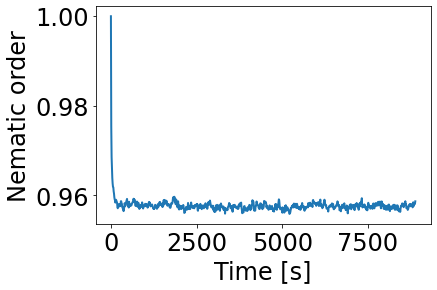

In [7]:
nematic_order = aa.nematic_order.calc_nematic_order(sy_dat)
_ = plt.plot(time_arr, nematic_order)
_ = plt.xlabel("Time [s]")
_ = plt.ylabel("Nematic order")

In [41]:
from scipy.spatial.transform import Rotation as R

def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    # Normalize vectors
    vec1 = vec1 / np.linalg.norm(vec1)
    vec2 = vec2 / np.linalg.norm(vec2)

    # Compute the cross product and dot product
    cross_prod = np.cross(vec1, vec2)
    dot_prod = np.dot(vec1, vec2)

    # Compute the rotation angle
    angle = np.arccos(dot_prod)

    # Compute the rotation axis
    axis = cross_prod / np.linalg.norm(cross_prod)

    # Use scipy to compute the rotation matrix
    rotation_vector = axis * angle
    rotation = R.from_rotvec(rotation_vector)
    rotation_matrix = rotation.as_matrix()

    return rotation_matrix

def filter_ghost_particles(com_arr, n_arr):
    ghost_vec = np.array([0,0,0])
    mask = np.all(com_arr[:,:] == ghost_vec, axis=1)
    return com_arr[~mask], n_arr[~mask]

def zrho_corr_new(n_arr, com_arr, time=None, distance=1.0, boxsize=None):  
    if time is None:
        positions, normals = filter_ghost_particles(com_arr, n_arr)
        # normal vector of segments, centerpoints, time and cutoff distcnce
    else:
        positions, normals = filter_ghost_particles(com_arr[:,:,time], n_arr[:,:,time])
    print(positions.shape)
    tree = cKDTree(positions, boxsize=boxsize)
    # pairs = tree.query_ball_tree(tree, r=distance)
    # for pair in pairs:
    #     print(len(pair))
    
    zpos = []
    rhopos = []
    zvec = np.array([0,0,1])
    rot_neigh_pos_list = []
    for cur_seg, pos in enumerate(positions):
        neighbor_inds = tree.query_ball_point(pos, r=distance)
        print(neighbor_inds)
        n_vec = normals[cur_seg,:] # Normal vector of current segment
        # neighbor_inds.remove(cur_seg) # Don't count self distances
        neigh_pos = positions[neighbor_inds,:] - positions[cur_seg,:]

        # Rotation matrix that transforms current segments orientation to zvec
        rot_mat = rotation_matrix_from_vectors(n_vec, zvec)
        # Rotate all neighbors to align with current zvec
        rot_neigh_pos_list += [np.einsum('ij,kj->ki', rot_mat, neigh_pos)]

    rot_neigh_pos_arr = np.vstack(rot_neigh_pos_list)
    rhopos = np.linalg.norm(rot_neigh_pos_arr[:,:2], axis=1)
    zpos = rot_neigh_pos_arr[:,2]
    return zpos, rhopos 

In [42]:
com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
n_arr = sy_dat[:, 5:8, :] - sy_dat[:, 2:5, :]
n_arr /= np.linalg.norm(n_arr, axis=1)[:,None]
zpos, rhopos = zrho_corr_new(n_arr,com_arr,-1,2.5, boxsize=5.0)
#zrho_corr_new(n_arr, com_arr, -1, 1.0)

(10000, 3)


AttributeError: 'list' object has no attribute 'shape'

3000000


/tmp/ipykernel_730887/3861063038.py:4: RuntimeWarning: divide by zero encountered in true_divide
  heatmap, rhoedges, zedges = np.histogram2d(rhoarr, zarr, bins=50, weights=1./rhoarr, range=[[0, 2], [-2, 2]])


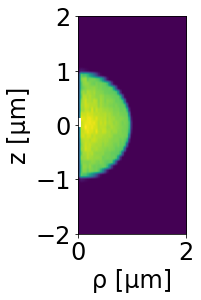

In [30]:
rhoarr = np.array(rhopos)
zarr = np.array(zpos)
print(len(rhoarr))
heatmap, rhoedges, zedges = np.histogram2d(rhoarr, zarr, bins=50, weights=1./rhoarr, range=[[0, 2], [-2, 2]])
extent = [rhoedges[0], rhoedges[-1], zedges[0], zedges[-1]]

heatmap = heatmap
_ = plt.clf()
_ = plt.imshow(heatmap.T, extent=extent, origin='lower')
_ = plt.xlabel("ρ [μm]")
_ = plt.ylabel("z [μm]")

(10000, 3)
27728406


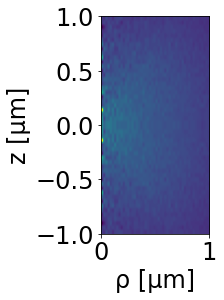

In [48]:
# make 10000 points in 3D space uniformly distributed between 0 and 5 in all dimensions
points = np.random.uniform(0, 5, (10000, 3, 1))
# make 10000 normal vectors all pointin in the (1,0,0) direction
n_verts = np.ones((10000, 3, 1))
zpos, rhopos = zrho_corr_new(n_verts,points,0,2.5, boxsize=None)
rhoarr = np.array(rhopos)
zarr = np.array(zpos)
print(len(rhoarr))
heatmap, rhoedges, zedges = np.histogram2d(rhoarr, zarr, bins=50, weights=1./rhoarr, range=[[0, 1], [-1, 1]])
extent = [rhoedges[0], rhoedges[-1], zedges[0], zedges[-1]]

heatmap = heatmap
_ = plt.clf()
_ = plt.imshow(heatmap.T, extent=extent, origin='lower')
_ = plt.xlabel("ρ [μm]")
_ = plt.ylabel("z [μm]")

In [38]:
# make a list of points that sit on a 3d cubic lattice of n points
n = 5
x = np.linspace(0, 5, n)
y = np.linspace(0, 5, n)
z = np.linspace(0, 5, n)
xv, yv, zv = np.meshgrid(x, y, z)
points = np.stack((xv, yv, zv), axis=-1).reshape(-1, 3)

# Define the vector and the number of repetitions
vector = np.array([0, 1.
                   , 0])
repetitions = n**3

# Create the matrix
matrix = np.tile(vector, (repetitions, 1))

print(matrix.shape)

print(points.shape)
# zpos, rhopos = zrho_corr_new(matrix,points, distance=2.5, boxsize=5.001)
zpos, rhopos = zrho_corr_new(matrix,points, distance=1.0, boxsize=[5.001,5.001,5.001])

(125, 3)
(125, 3)
(124, 3)
(300,)
[  0 100  20 120 124 124 124 124 124 124 124 124 124 124 124 124 124 124
 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124
 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124
 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124
 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124
 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124
 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124
 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124
 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124
 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124
 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124
 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124
 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124
 124 124 124 124 

IndexError: index 124 is out of bounds for axis 0 with size 124

In [9]:
rhoarr = np.array(rhopos)
zarr = np.array(zpos)
print(len(rhoarr))
heatmap, rhoedges, zedges = np.histogram2d(rhoarr, zarr, bins=50, weights=1./(rhoarr + .1), range=[[0, 2], [-2, 2]])
extent = [rhoedges[0], rhoedges[-1], zedges[0], zedges[-1]]

heatmap = heatmap
_ = plt.clf()
_ = plt.imshow(heatmap.T, extent=extent, origin='lower')
_ = plt.xlabel("ρ [μm]")
_ = plt.ylabel("z [μm]")

NameError: name 'rhopos' is not defined

# Saving post-processed data with HDF5

While the above calculation happened quickly, it is possible that the analysis you want to do takes a long time. In this case, you can save the data to a file for later use. Let's save the nematic order data we just calculated.

In [23]:
# Open an hdf5 file for writing, (w = write, will overwrite existing files)
with h5py.File(opts.analysis_dir / 'nematic_order.h5', 'w') as h5_data:
    # Save the RunConfig string to the attributes for easy access later
    h5_data.attrs['RunConfig'] = yaml.dump(param_dict)
    h5_data.attrs['ProteinConfig'] = yaml.dump(protein_dict)
    # Save the time array
    _ = h5_data.create_dataset('time', data=time_arr)
    # Save the nematic order array
    _ = h5_data.create_dataset('nematic_order', data=nematic_order)

Let's read in the data and see if we get the same thing as before.

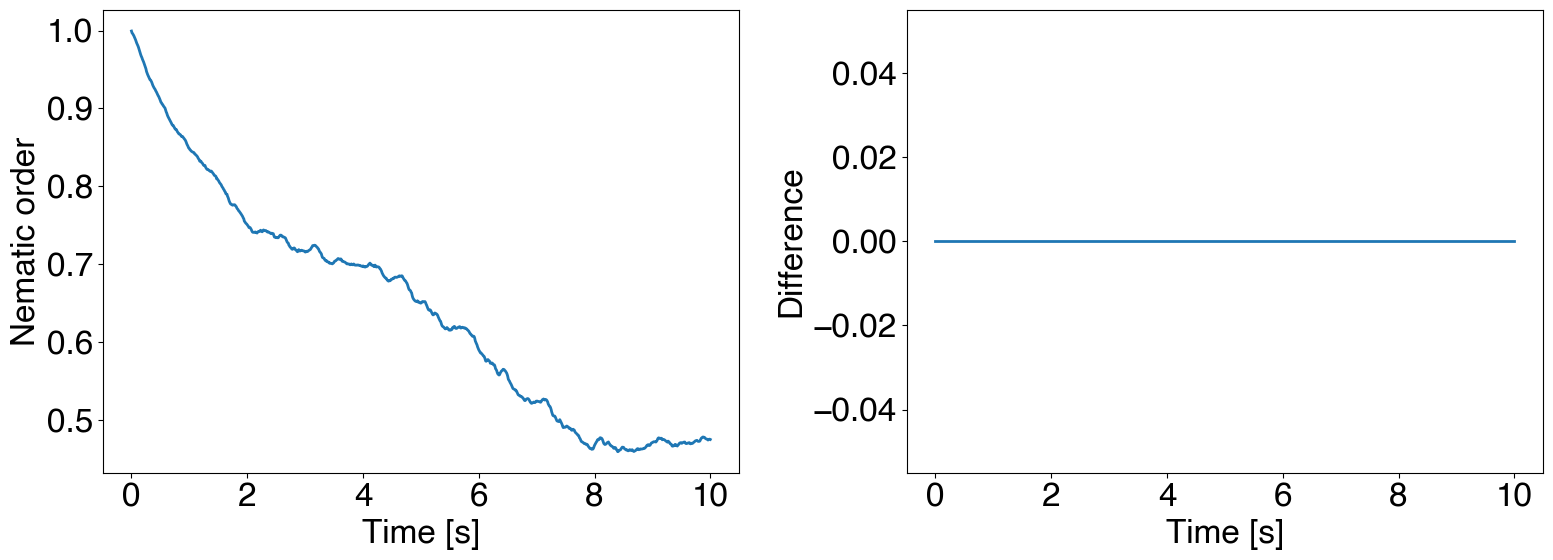

In [28]:
with h5py.File(opts.analysis_dir / 'nematic_order.h5', 'r') as h5_data:
    time_arr = h5_data['time'][:] # Load in time array, [:] loads data as numpy array
    # Load nematic data
    new_nematic_order = h5_data['nematic_order'][:]

# Plot the nematic order parameter
fig, axarr = plt.subplots(1,2, figsize=(16, 6))

_ = axarr[0].plot(time_arr, new_nematic_order)
_ = axarr[0].set_xlabel("Time [s]")
_ = axarr[0].set_ylabel("Nematic order")

_ = axarr[1].plot(time_arr, nematic_order - new_nematic_order)
_ = axarr[1].set_xlabel("Time [s]")
_ = axarr[1].set_ylabel("Difference")
fig.tight_layout()  

Notice how much faster that was then calculating the nematic order again. This is especially useful if you want to plot the data in different ways or if you want to compare the data from different simulations.

If you perform another analysis and would like to include it in the same file, you can add it using the `mode='r+'`(read and append) or `mode='a'`(append). You can still overwrite data already in the hdf5 file if the same dataset name exists, so be careful. It is often wiser to make another file if you are unsure.

In [31]:
# Open an hdf5 file and show tree structure
with h5py.File(opts.analysis_dir / 'nematic_order.h5', 'r+') as h5_data:
    print("## Previous data structure ##")
    h5_data.visit(print) # Print the tree structure of the hdf5 file

    new_grp = h5_data.create_group('new_group') # Create a new group
    new_grp.create_dataset('new_dataset', data=np.arange(10)) # Create a new dataset

    print("## Post modifications of data structure ##")
    h5_data.visit(print) # Print the tree structure of the hdf5 file


## Previous data structure ##
nematic_order
time


<HDF5 dataset "new_dataset": shape (10,), type "<i8">

## Post modifications of data structure ##
nematic_order
new_group
new_group/new_group
new_group/new_group/new_dataset
time


In [53]:
k_points= 100
n_time_points= 10
ts_start= 100
n_points = 20000
box_size = 10.08
time_arr = np.linspace(0, 100, 1000)

# tk_arr = np.pi*((2*torch.range(1,k_points)+1)/(box_size))
tk_arr = torch.linspace(0, 100, k_points) * 2.*np.pi / box_size

tkx_arr = torch.vstack([tk_arr, torch.zeros(k_points), torch.zeros(k_points)]).T.to(
    device
)
tky_arr = torch.vstack([torch.zeros(k_points), tk_arr, torch.zeros(k_points)]).T.to(
    device
)
tkz_arr = torch.vstack([torch.zeros(k_points), torch.zeros(k_points), tk_arr]).T.to(
    device
)
# Randomly distribute 8000 points in a box 1.08 x 1.08 x 1.08


# Generate 8000 random points in a box of size 1.08 x 1.08 x 1.08
tcom_arr = (torch.rand(n_points, 3,1000).to(device) - .5)*box_size

time_step = (len(time_arr) - ts_start) // n_time_points

# Full Q-tensor structure factor
# timer.milestone()
Sx_time_arr = torch.zeros((k_points, n_time_points)).to(device)
Sy_time_arr = torch.zeros((k_points, n_time_points)).to(device)
Sz_time_arr = torch.zeros((k_points, n_time_points)).to(device)

for i in range(n_time_points):
    time_ind = ts_start + i * time_step
    tcom = tcom_arr[:, :, time_ind]

    # tQ_arr = aa.nematic_order.make_nematic_tensor_arr(tdir, device)
    # tQ_arr = torch.complex(tQ_arr, torch.zeros_like(tQ_arr))

    Sx_time_arr[:, i] = aa.nematic_order.make_structure_factor(
         tcom, tkx_arr, device=device
    )
    Sy_time_arr[:, i] = aa.nematic_order.make_structure_factor(
        tcom, tky_arr, device=device
    )
    Sz_time_arr[:, i] = aa.nematic_order.make_structure_factor(
        tcom, tkz_arr, device=device
    )

tensor([[ 0.0000e+00,  1.7162e+00,  3.4324e+00,  ...,  1.6647e+02,
          1.6819e+02,  1.6990e+02],
        [ 0.0000e+00, -2.8024e-01, -5.6048e-01,  ..., -2.7183e+01,
         -2.7463e+01, -2.7744e+01],
        [ 0.0000e+00, -2.6353e+00, -5.2706e+00,  ..., -2.5562e+02,
         -2.5826e+02, -2.6089e+02],
        ...,
        [ 0.0000e+00, -3.0353e+00, -6.0705e+00,  ..., -2.9442e+02,
         -2.9746e+02, -3.0049e+02],
        [ 0.0000e+00, -1.8491e+00, -3.6982e+00,  ..., -1.7936e+02,
         -1.8121e+02, -1.8306e+02],
        [ 0.0000e+00,  3.0797e-01,  6.1594e-01,  ...,  2.9873e+01,
          3.0181e+01,  3.0489e+01]])
tensor([[ 0.0000e+00,  2.9261e+00,  5.8522e+00,  ...,  2.8383e+02,
          2.8676e+02,  2.8968e+02],
        [ 0.0000e+00,  2.5674e-01,  5.1348e-01,  ...,  2.4904e+01,
          2.5161e+01,  2.5417e+01],
        [ 0.0000e+00, -2.3691e+00, -4.7383e+00,  ..., -2.2981e+02,
         -2.3218e+02, -2.3454e+02],
        ...,
        [ 0.0000e+00, -2.5614e+00, -5.1227e+00

tensor(-8.2799e-05)

tensor(-8.1442e-05)

tensor([ 9.9990e-01,  9.2080e-05,  6.2533e-05, -2.7684e-06,  6.8814e-05,
         1.7810e-05,  6.1189e-05,  6.1685e-05,  4.5411e-05,  1.9430e-05,
         1.1553e-05,  3.0220e-05,  1.3867e-04, -3.1361e-05,  4.3531e-05,
         1.2893e-05,  1.2114e-04,  9.6769e-05,  2.3235e-06,  6.2579e-05,
        -1.0714e-06, -4.6428e-06,  5.9682e-06,  2.2952e-05,  7.5876e-05,
         2.7689e-05, -3.4037e-05,  5.6364e-05, -1.7086e-05,  1.3685e-05,
         9.6447e-06, -7.6561e-06,  5.5998e-05,  3.0840e-05, -1.1800e-05,
         3.0410e-06,  6.1911e-05, -7.6406e-06,  3.6652e-06,  5.3515e-06,
         2.1895e-05, -2.6226e-05, -3.2512e-05, -1.6372e-05, -2.3884e-05,
         1.3238e-05, -1.5442e-05,  1.2039e-05,  7.4908e-06,  4.0184e-05,
        -2.4216e-05, -5.1416e-05, -4.9555e-05, -4.5371e-05, -2.5415e-05,
        -1.3219e-05, -3.7192e-05, -1.8278e-05, -3.3488e-05, -3.7281e-05,
        -2.3470e-05, -3.4699e-05,  1.3568e-05, -1.4481e-05, -2.0983e-05,
        -3.5554e-05, -2.5430e-05, -5.6676e-05, -1.1

/var/folders/st/fgw_z95d55x71m603j17ld300000gr/T/ipykernel_61641/131504020.py:26: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  _ = axarr.set_xlim(0, 2)


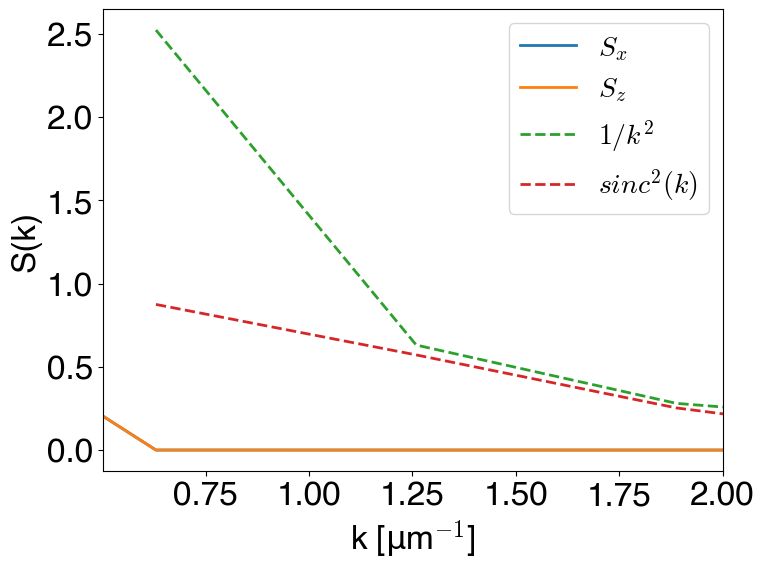

In [57]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))


_ = axarr.loglog(tk_arr, Sx_time_arr.mean(dim=1).cpu(), label="$ S_x$")
_ = axarr.loglog(tk_arr, Sz_time_arr.mean(dim=1).cpu(), label="$ S_z$")

min(Sx_time_arr.mean(dim=1).cpu())
min(Sz_time_arr.mean(dim=1).cpu())

print(Sx_time_arr.mean(dim=1).cpu())

_ = axarr.loglog(
    tk_arr,
     (1./ ((tk_arr) ** 2)),
    label="$1/k^2$",
    linestyle="--",
)

_ = axarr.loglog(
    tk_arr,
     (torch.sin(tk_arr)**2 / ((tk_arr) ** 2)),
    label="$sinc^2(k)$",
    linestyle="--",
)

_ = axarr.set_xlim(0, 2)
# _ = axarr.set_ylim(0.0001, 1)

# _ = axarr.set_xscale("linear")
# _ = axarr.set_yscale("linear")
_ = axarr.set_xlabel("k [μm$^{-1}$]")
_ = axarr.set_ylabel("S(k)")
_ = axarr.legend()